In [1]:
import os
load_dir = 'performance'
excludes = [
    'vanilla',
    'synthchain_vanilla3_no_repeat_10_1',
    'synthchain_vanilla3_no_repeat_20_1',
    'synthchain_vanilla3_no_repeat_5_1',
    'synthchain_vanilla_5_1',
    'synthchain_vanilla3_5_1',
    'synthchain_vanilla2_5_1',
    'synthchain_vanilla4_5_1',
    'synthchain_vanilla3_no_repeat_30_1',
    'gridpuzzle_claude_context_clue_only.gpt-4o-mini.json',
           'gridpuzzle',
] #['deltabench']
ands = [
    'insertion',
    # 'multi_sources_single_sink',
    # '.better_prompt1'
    'synthchain',
    '.no_cot'
    # '.split_raw_derived',
    # 'synthchain'
]
filenames = [filename for filename in os.listdir(load_dir) \
             if filename.endswith('.json') and \
             not any([exclude in filename for exclude in excludes]) and \
            all([a in filename for a in ands])]
filenames

['synthchain_insertion_v5_i2_el2.gpt-4o-mini.no_cot.json',
 'synthchain_insertion_v5_i5_el2.gpt-4o-mini.no_cot.json',
 'synthchain_insertion_v5_i1_el2.gpt-4o-mini.no_cot.json']

In [2]:
# filenames = [
#     'deltabench_sections.gpt-4o-mini.json'
# ]

In [3]:
import json

filename = filenames[0]

dataset_name, model_name = filename.split('.')[0], filename.split('.')[1]

with open(os.path.join(load_dir, filename)) as input_file:
    results = json.load(input_file)

In [8]:
import os
import json
import numpy as np
from collections import OrderedDict, defaultdict

# ── USER SETTINGS ─────────────────────────────────────────────────────────────
load_dir = 'performance'

# order+latex names for methods
name_mapping = OrderedDict([
    ('Stability',   r'\cert{}-1'),
    ('Stability-0.95',   r'\cert{}-0.95'),
    ('Stability-bin',   r'\cert{}-bin-1'),
    ('Stability-bin-0.95',   r'\cert{}-bin-0.95'),
    ('Stability-Test',   r'\cert{}-Test'),
    ('Entail-Prev', r'\entailprev{}'),
    ('Entail-Raw',  r'\entailraw{}'),
    ('ROSCOE-LI-Self-Contra',   r'ROSCOE-LI-Self'),
    ('ROSCOE-LI-Source-Contra',   r'ROSCOE-LI-Source'),
    ('ReCEval-Intra',   r'ReCEval-Intra'),
    ('ReCEval-Inter-Contra',   r'ReCEval-Inter'),
    ('LLM-Judge',   r'\llmjudge{}'),
    ('LLM-Judge-Old',   r'\llmjudge{}-Old'),
    ('LLM-Judge-Whole',   r'\llmjudge{}-Whole'),
    ('PRM',         r'\prm{}'),
])

# map dataset IDs to nice display names
dataset_name_map = OrderedDict([
    # 'deltabench_sections': 'DeltaBench',
    # 'gridpuzzle_claude_context_clue_only': 'GridPuzzle-Claude',
    # 'gridpuzzle_claude_context_clue_only.20': 'GridPuzzle-Claude.20',
    # 'gridpuzzle_gemini_context_clue_only': 'GridPuzzle-Gemini',
    # 'gridpuzzle_gpt_context_clue_only': 'GridPuzzle-GPT',
    # 'gridpuzzle_llama_context_clue_only': 'GridPuzzle-Llama',
    # 'gridpuzzle_mistral_context_clue_only': 'GridPuzzle-Mistral',
    # 'dataset2':            'OtherDS',
    # 'synthchain_vanilla_10': 'SynthChain10',
    # 'synthchain_vanilla_20': 'SynthChain20',
    # 'synthchain_vanilla_30': 'SynthChain30',
    # 'synthchain_vanilla_50': 'SynthChain50'
    # ('synthchain_vanilla3_no_repeat_5_2', r'\ourdata{}-5'),
    # ('synthchain_vanilla3_no_repeat_10_2', r'\ourdata{}-10'),
    # ('synthchain_vanilla3_no_repeat_20_2', r'\ourdata{}-20'),
    # ('synthchain_vanilla3_no_repeat_30_2', r'\ourdata{}-30'),
    # ('synthchain_vanilla3_no_repeat_50_2', r'\ourdata{}-50'),
    # ('synthchain_multi_sources_single_sink_s3_d3_el2', r'\ourdata{}-s3d3'),
    # ('synthchain_multi_sources_single_sink_s3_d5_el2', r'\ourdata{}-s3d5'),
    # ('synthchain_multi_sources_single_sink_s5_d3_el2', r'\ourdata{}-s5d3'),
    # ('synthchain_multi_sources_single_sink_s5_d5_el2', r'\ourdata{}-s5d5')
    ('synthchain_insertion_v5_i1_el2', r'\ourdata{}-v5i1'),
    ('synthchain_insertion_v5_i2_el2', r'\ourdata{}-v5i2'),
    ('synthchain_insertion_v5_i5_el2', r'\ourdata{}-v5i5'),
    # add more as needed...
])

# map raw model IDs to display names
model_name_map = {
    'gpt-4o-mini': 'GPT-4o-mini',
    'flan-t5-xxl':      'Flan-t5-xxl',
    'qwen2.5-math-prm-7b':      'Qwen2.5-Math-PRM-7B',
    # add more as needed...
}


In [9]:
# ── LOAD ALL RESULTS ───────────────────────────────────────────────────────────
results_by_model = defaultdict(dict)
for fn in filenames:
    if not fn.endswith('.json'):
        continue
    ds, model = fn.split('.')[:2]
    if len(fn.split('.')) == 5:
        ds = ds + '.' + fn.split('.')[3]
    path = os.path.join(load_dir, fn)
    results_by_model[model][ds] = json.load(open(path))

# ── SORTED LIST OF DATASETS ───────────────────────────────────────────────────
all_datasets = sorted({ds for m in results_by_model for ds in results_by_model[m]})
n_ds = len(all_datasets)

# ── PRECOMPUTE BEST AND SECOND-BEST MEAN METRICS FOR BOLDING/UNDERLINING ─────
best_metrics = {}
for model, ds_dict in results_by_model.items():
    best_metrics[model] = {}
    for ds in all_datasets:
        means = {'rec': [], 'prec': [], 'f1': []}
        if ds in ds_dict:
            for method in name_mapping:
                if method in ds_dict[ds]:
                    r = ds_dict[ds][method]
                    means['rec'].append(np.mean(r['rec']))
                    means['prec'].append(np.mean(r['prec']))
                    means['f1'].append(np.mean(r['f1']))
        # find top two
        def top_two(arr):
            if not arr:
                return None, None
            uniq = sorted(set(arr), reverse=True)
            return uniq[0], (uniq[1] if len(uniq) > 1 else None)
        best_r, second_r = top_two(means['rec'])
        best_p, second_p = top_two(means['prec'])
        best_f, second_f = top_two(means['f1'])
        best_metrics[model][ds] = {
            'rec': best_r, 'second_rec': second_r,
            'prec': best_p, 'second_prec': second_p,
            'f1': best_f, 'second_f1': second_f,
        }
# ── TRANSPOSED TABLE ─────────────────────────────────────────────────────────
add_std = False
for model in sorted(results_by_model):
    disp_model = model_name_map.get(model, model)
    print(f"% Results for {disp_model}")
    print(r"\begin{tabular}{lccc}")
    print(r"\toprule")
    print(r"Dataset / Method & Recall & Precision & F1 \\")
    print(r"\midrule")
    # for ds in all_datasets:
    for ds in dataset_name_map:
        ds_disp = dataset_name_map.get(ds, ds)
        # dataset header spanning all 4 cols
        print(rf"\multicolumn{{4}}{{l}}{{\textbf{{{ds_disp}}}}} \\")
        for method_key, tex_name in name_mapping.items():
            # print('----', method_key, tex_name, '----')
            
            ds_res = results_by_model[model].get(ds, {})
            # print(ds_res.keys())
            if method_key not in ds_res:
                continue
            r = ds_res[method_key]
            rec_arr, prec_arr, f1_arr = (np.array(r[k]) for k in ("rec","prec","f1"))
            rec_m, rec_s   = rec_arr.mean(),   rec_arr.std(ddof=1)
            prec_m, prec_s = prec_arr.mean(),  prec_arr.std(ddof=1)
            f1_m, f1_s     = f1_arr.mean(),    f1_arr.std(ddof=1)

            # bold / underline logic (same as before)
            bm = best_metrics[model][ds]
            def styl(mean, std, best, second):
                if add_std:
                    cell = f"{mean:.3f} $\pm$ {std:.3f}"
                else:
                    cell = f"{mean:.3f}"
                if best is not None and abs(mean-best)<1e-12:
                    return rf"\textbf{{{cell}}}"
                if second is not None and abs(mean-second)<1e-12:
                    return rf"\underline{{{cell}}}"
                return cell

            row = " & ".join([
                tex_name,
                styl(rec_m,   rec_s,   bm["rec"],    bm["second_rec"]),
                styl(prec_m,  prec_s,  bm["prec"],   bm["second_prec"]),
                styl(f1_m,    f1_s,    bm["f1"],     bm["second_f1"])
            ]) + r" \\"

            print(row)
        print(r"\midrule")
    print(r"\bottomrule")
    print(r"\end{tabular}")
    print("\n")


% Results for GPT-4o-mini
\begin{tabular}{lccc}
\toprule
Dataset / Method & Recall & Precision & F1 \\
\midrule
\multicolumn{4}{l}{\textbf{\ourdata{}-v5i1}} \\
\cert{}-1 & 0.985 & 0.950 & 0.965 \\
\cert{}-0.95 & 0.990 & \underline{0.998} & \underline{0.994} \\
\entailprev{} & \underline{0.992} & 0.974 & 0.982 \\
\entailraw{} & 0.900 & 0.788 & 0.813 \\
ROSCOE-LI-Self & 0.975 & 0.918 & 0.942 \\
ROSCOE-LI-Source & 0.690 & 0.626 & 0.545 \\
ReCEval-Intra & 0.500 & 0.100 & 0.167 \\
ReCEval-Inter & 0.755 & 0.671 & 0.590 \\
\llmjudge{} & \textbf{1.000} & \textbf{1.000} & \textbf{1.000} \\
\midrule
\multicolumn{4}{l}{\textbf{\ourdata{}-v5i2}} \\
\cert{}-1 & \textbf{1.000} & \textbf{1.000} & \textbf{1.000} \\
\cert{}-0.95 & \underline{0.995} & \underline{0.998} & \underline{0.996} \\
\entailprev{} & 0.990 & 0.981 & 0.985 \\
\entailraw{} & 0.863 & 0.823 & 0.815 \\
ROSCOE-LI-Self & 0.965 & 0.951 & 0.956 \\
ROSCOE-LI-Source & 0.635 & 0.642 & 0.555 \\
ReCEval-Intra & 0.500 & 0.167 & 0.250 \\
ReCEval

In [15]:
import os
import json
import numpy as np
from collections import defaultdict

# ── LOAD ALL RESULTS ───────────────────────────────────────────────────────────
results_by_model = defaultdict(dict)
for fn in filenames:
    if not fn.endswith('.json'):
        continue
    ds, model = fn.split('.')[:2]
    if len(fn.split('.')) == 5:
        ds = ds + '.' + fn.split('.')[3]
    path = os.path.join(load_dir, fn)
    with open(path) as f:
        results_by_model[model][ds] = json.load(f)

# ── SORTED LIST OF DATASETS ───────────────────────────────────────────────────
all_datasets = sorted({ds for m in results_by_model for ds in results_by_model[m]})
n_ds = len(all_datasets)

# ── PRECOMPUTE BEST AND SECOND-BEST MEAN METRICS FOR BOLDING/UNDERLINING ─────
best_metrics = {}
for model, ds_dict in results_by_model.items():
    best_metrics[model] = {}
    for ds in all_datasets:
        means = {'rec': [], 'prec': [], 'f1': []}
        if ds in ds_dict:
            for method in name_mapping:
                if method in ds_dict[ds]:
                    r = ds_dict[ds][method]
                    means['rec'].append(np.mean(r['rec']))
                    means['prec'].append(np.mean(r['prec']))
                    means['f1'].append(np.mean(r['f1']))
        def top_two(arr):
            if not arr:
                return None, None
            uniq = sorted(set(arr), reverse=True)
            return uniq[0], (uniq[1] if len(uniq) > 1 else None)
        best_r, second_r = top_two(means['rec'])
        best_p, second_p = top_two(means['prec'])
        best_f, second_f = top_two(means['f1'])
        best_metrics[model][ds] = {
            'rec': best_r, 'second_rec': second_r,
            'prec': best_p, 'second_prec': second_p,
            'f1': best_f, 'second_f1': second_f,
        }

# ── TRANSPOSED TABLE WITH BOOTSTRAP STD ───────────────────────────────────────
add_std = True  # now include mean ± std
for model in sorted(results_by_model):
    disp_model = model_name_map.get(model, model)
    print(f"% Results for {disp_model}")
    print(r"\begin{tabular}{lccc}")
    print(r"\toprule")
    print(r"Dataset / Method & Recall & Precision & F1 \\")
    print(r"\midrule")
    for ds in dataset_name_map:
        ds_disp = dataset_name_map.get(ds, ds)
        print(rf"\multicolumn{{4}}{{l}}{{\textbf{{{ds_disp}}}}} \\")
        for method_key, tex_name in name_mapping.items():
            ds_res = results_by_model[model].get(ds, {})
            if method_key not in ds_res:
                continue
            r = ds_res[method_key]
            rec_arr, prec_arr, f1_arr = (np.array(r[k]) for k in ("rec","prec","f1"))
            rec_m, rec_s   = rec_arr.mean(),   rec_arr.std(ddof=1)
            prec_m, prec_s = prec_arr.mean(),  prec_arr.std(ddof=1)
            f1_m, f1_s     = f1_arr.mean(),    f1_arr.std(ddof=1)

            bm = best_metrics[model][ds]
            def styl(mean, std, best, second):
                cell = rf"{mean:.3f}$\pm$ {std:.3f}" if add_std else f"{mean:.3f}"
                if best is not None and abs(mean-best) < 1e-12:
                    return rf"\textbf{{{cell}}}"
                if second is not None and abs(mean-second) < 1e-12:
                    return rf"\underline{{{cell}}}"
                return cell

            row = " & ".join([
                tex_name,
                styl(rec_m,   rec_s,   bm['rec'],    bm['second_rec']),
                styl(prec_m,  prec_s,  bm['prec'],   bm['second_prec']),
                styl(f1_m,    f1_s,    bm['f1'],     bm['second_f1'])
            ]) + r" \\"  # double backslash for LaTeX line break
            print(row)
        print(r"\midrule")
    print(r"\bottomrule")
    print(r"\end{tabular}")


% Results for GPT-4o-mini
\begin{tabular}{lccc}
\toprule
Dataset / Method & Recall & Precision & F1 \\
\midrule
\multicolumn{4}{l}{\textbf{\ourdata{}-v5i1}} \\
\cert{}-1 & 0.985$\pm$ 0.014 & 0.950$\pm$ 0.046 & 0.965$\pm$ 0.032 \\
\cert{}-0.95 & 0.990$\pm$ 0.022 & \underline{0.998$\pm$ 0.005} & \underline{0.994$\pm$ 0.015} \\
\entailprev{} & \underline{0.992$\pm$ 0.011} & 0.974$\pm$ 0.038 & 0.982$\pm$ 0.026 \\
\entailraw{} & 0.900$\pm$ 0.027 & 0.788$\pm$ 0.030 & 0.813$\pm$ 0.038 \\
ROSCOE-LI-Self & 0.975$\pm$ 0.009 & 0.918$\pm$ 0.025 & 0.942$\pm$ 0.019 \\
ROSCOE-LI-Source & 0.690$\pm$ 0.062 & 0.626$\pm$ 0.038 & 0.545$\pm$ 0.058 \\
ReCEval-Intra & 0.500$\pm$ 0.000 & 0.100$\pm$ 0.000 & 0.167$\pm$ 0.000 \\
ReCEval-Inter & 0.755$\pm$ 0.047 & 0.671$\pm$ 0.021 & 0.590$\pm$ 0.066 \\
\llmjudge{} & \textbf{1.000$\pm$ 0.000} & \textbf{1.000$\pm$ 0.000} & \textbf{1.000$\pm$ 0.000} \\
\midrule
\multicolumn{4}{l}{\textbf{\ourdata{}-v5i2}} \\
\cert{}-1 & \textbf{1.000$\pm$ 0.000} & \textbf{1.000$\pm$

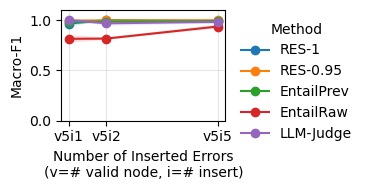

In [8]:
# ── FIGURE: TREND LINES WITH ±1 STD SHADE ───────────────────────────────────
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt

# Option 1: using rcParams directly
plt.rcParams['font.family'] = 'DejaVu Sans'
# plt.rcParams['font.size']   = 8

# # Optionally customize specific elements:
# plt.rcParams['axes.titlesize']   = 8
# plt.rcParams['axes.labelsize']   = 8
# plt.rcParams['xtick.labelsize']  = 8
# plt.rcParams['ytick.labelsize']  = 8
# plt.rcParams['legend.fontsize']  = 8

ourdata_name = 'ClaimTrees'

display_name_mapping = {
    r'\cert{}': 'RES',
    r'\entailprev{}': 'EntailPrev',
    r'\entailraw{}': 'EntailRaw',
    r'\llmjudge{}': 'LLM-Judge',
    r'\prm{}': 'PRM'
}

metric_key = "f1"                                   # or "rec" / "prec"
datasets_order = list(dataset_name_map.keys())      # preserves your chosen order
x_labels       = [dataset_name_map[d].replace(r'\ourdata{}', ourdata_name).split('-')[-1] for d in datasets_order]
# x_pos          = np.arange(len(datasets_order))
# x_pos          = np.arange(len(datasets_order))
x_pos = [int(item.split('i')[-1]) for item in x_labels]

plt.figure(figsize=(2.6, 2.0))
for method_key, disp_name in name_mapping.items():
    y_means, y_stds = [], []
    for ds in datasets_order:
        ds_res = results_by_model[model].get(ds, {})
        if method_key not in ds_res:
            y_means.append(np.nan)
            y_stds.append(np.nan)
            continue
        vals = np.asarray(ds_res[method_key][metric_key])
        y_means.append(vals.mean())
        y_stds.append(vals.std(ddof=1))
    
    if np.isnan(y_means[0]):
        continue

    y_means = np.array(y_means, dtype=float)
    y_stds  = np.array(y_stds,  dtype=float)

    # main line
    for k, v in display_name_mapping.items():
        disp_name = disp_name.replace(k, v)
    plt.plot(x_pos, y_means, marker="o", label=disp_name)
    # shaded ±1 σ band (Matplotlib skips NaNs automatically)
    plt.fill_between(x_pos, y_means - y_stds, y_means + y_stds,
                     alpha=0.15, linewidth=0)
plt.xticks(x_pos, x_pos)
plt.xlabel('Number of Inserted Errors\n(v=# valid node, i=# insert)')
plt.xticks(x_pos, x_labels)
plt.ylabel(f"Macro-{metric_key.upper()}")
plt.ylim(0, 1.1)                      # adjust if necessary
plt.grid(alpha=0.3)
plt.tight_layout()
plt.legend(title="Method", bbox_to_anchor=(1.02, 1),
           loc="upper left", frameon=False)
# plt.title(f"Trend of {metric_key.upper()} across datasets\n(mean ± 1 SD)")
plt.savefig('figures/insertions.pdf', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()


In [26]:
1

1

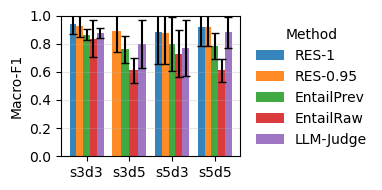

In [19]:
# ── FIGURE: TREND LINES WITH ±1 STD SHADE ───────────────────────────────────
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt

# Option 1: using rcParams directly
plt.rcParams['font.family'] = 'DejaVu Sans'
# plt.rcParams['font.size']   = 8

# # Optionally customize specific elements:
# plt.rcParams['axes.titlesize']   = 8
# plt.rcParams['axes.labelsize']   = 8
# plt.rcParams['xtick.labelsize']  = 8
# plt.rcParams['ytick.labelsize']  = 8
# plt.rcParams['legend.fontsize']  = 8

ourdata_name = 'ClaimTrees'

display_name_mapping = {
    r'\cert{}': 'RES',
    r'\entailprev{}': 'EntailPrev',
    r'\entailraw{}': 'EntailRaw',
    r'\llmjudge{}': 'LLM-Judge',
    r'\prm{}': 'PRM'
}

metric_key = "f1"                                   # or "rec" / "prec"
datasets_order = list(dataset_name_map.keys())      # preserves your chosen order
x_labels       = [dataset_name_map[d].replace(r'\ourdata{}', ourdata_name).split('-')[-1] for d in datasets_order]
x_pos          = np.arange(len(datasets_order))
# x_pos = [int(item.split('-')[-1]) for item in x_labels]

# ── FIGURE: GROUPED BAR PLOT, CONSISTENT COLOURS ────────────────────────────
plt.figure(figsize=(2.6, 2.0))

# 1) Map every surviving method → display name
disp_names = {}
for m_key, disp in name_mapping.items():
    for k, v in display_name_mapping.items():
        disp = disp.replace(k, v)
    disp_names[m_key] = disp

# 2) Which methods have data anywhere?
methods_with_data = []
for m_key in name_mapping:
    for ds in datasets_order:
        ds_res = results_by_model[model].get(ds, {})
        if m_key in ds_res and not np.isnan(ds_res[m_key][metric_key]).all():
            methods_with_data.append(m_key)
            break                       # found data for this method

# 3) Give each method a colour
colour_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
method_colour = {
    m_key: colour_cycle[i % len(colour_cycle)]
    for i, m_key in enumerate(methods_with_data)
}

group_cent  = x_pos
group_width = 0.80                     # full width allotted per dataset
plotted_once = {m: False for m in methods_with_data}

# 4) Draw bars dataset-by-dataset
for j, ds in enumerate(datasets_order):
    # gather valid methods for this dataset
    valid = []
    for m_key in methods_with_data:
        ds_res = results_by_model[model].get(ds, {})
        if m_key not in ds_res:
            continue
        vals = np.asarray(ds_res[m_key][metric_key])
        if np.isnan(vals).all():
            continue
        valid.append((m_key, vals.mean(), vals.std(ddof=1)))

    n = len(valid)
    if n == 0:
        continue

    bar_w = group_width / n
    for k, (m_key, mean, std) in enumerate(valid):
        x = group_cent[j] - group_width/2 + (k + 0.5)*bar_w
        plt.bar(
            x, mean, width=bar_w,
            yerr=std, capsize=3, alpha=0.9,
            color=method_colour[m_key],
            label=disp_names[m_key] if not plotted_once[m_key] else None
        )
        plotted_once[m_key] = True      # only label first occurrence

# 5) Cosmetics
plt.xticks(group_cent, x_labels)
plt.ylabel(f"Macro-{metric_key.upper()}")
plt.ylim(0, 1)
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.legend(title="Method", bbox_to_anchor=(1.02, 1),
           loc="upper left", frameon=False)
plt.savefig('figures/wide_chains_bar.pdf', dpi=300,
            bbox_inches='tight', pad_inches=0)
plt.show()

